In [22]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
config_file = './configs/lego.yaml'
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

In [24]:
from utils.DataLoaderLego import DataLoaderLego

data_loader = DataLoaderLego(config['data'])

images, poses, focal = data_loader.getDataset('train')

In [25]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()

In [26]:
from utils.Camera import Camera

cameras = []
H, W = images[0].shape[:2]

for i in range(images.shape[0]):
    cameras.append(Camera(H, W, poses[i], focal, device))


In [27]:
from utils.Renderer import Renderer

renderer = Renderer(config['renderer'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
6
Epoch: 0, Loss: 0.18198025226593018, Secs per iter: 0.06510425567626953
Test PSNR: 7.184934616088867
torch.Size([10000, 3])


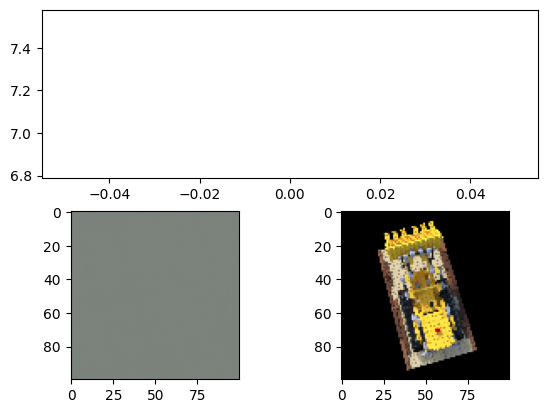

KeyboardInterrupt: 

In [28]:
%load_ext autoreload
%autoreload 2


from models.TinyNerf import TinyNerf
from utils.TrainerTinyNerf import TrainerTinyNerf
import imageio.v3 as iio

test_img = "nerf_synthetic/lego/val/r_0.png"
test_img = iio.imread(test_img)[:,:,:3]
test_img = torch.tensor(test_img)
test_img = torch.nn.functional.interpolate(test_img[None,...].permute(
            0, 3, 1, 2), (100, 100), mode='bilinear', align_corners=False).permute(0, 2, 3, 1)[0]
test_img = test_img/255

test_pose = torch.tensor([
                [
                    -0.963964581489563,
                    -0.2611401677131653,
                    0.0507759265601635,
                    0.2046843022108078
                ],
                [
                    0.26603081822395325,
                    -0.9462433457374573,
                    0.18398693203926086,
                    0.7416750192642212
                ],
                [
                    7.450580596923828e-09,
                    0.1908649355173111,
                    0.9816163182258606,
                    3.957021951675415
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

model = TinyNerf(config['model']['L_xyz'])
trainer = TrainerTinyNerf(model, device, images, cameras, renderer, config['trainer'])
trainer.train(test_img[None,...], test_pose[None,...], focal)